### A/B Testing in Python

- The purpose of this tutorial :
1. Learn the process of analyzing an A/B testing from explaining the basic knowledge to formulate the hypothesis and interpreting the results to estimate which ad asset results in more sales

### Data exploration

In [25]:
#import libraries 
import pandas as pd
import numpy as np
import random 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
random.seed(42)

In [26]:
# data exploration
df = pd.read_csv("downloads/data.csv")
print(df.shape)

(294478, 5)


In [27]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


control group : users who visit the old design page.

treatment group: users who visit the new design page.

converted = 0: users did not buy the product.

converted = 1: users bought the product.

In [28]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_sessions = session_counts[session_counts > 1].count()

print(f'The number of users that appear multiple times in the dataset: {multi_sessions}')

The number of users that appear multiple times in the dataset: 3894


In [29]:
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

#Now we can see ther user experience only one page
pd.crosstab(df['group'],df['landing_page'])

The updated dataset now has 286690 entries


landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


### The Hypotheses:

The hypothesis is that the new design performs better than the old design and leads to a higher conversion rate.

Null Hypothesis H : p = p Two design have the same impact

Alternative hypothesis H : ≠ p two design s have the different impacts,

where p and p are the conversion rate of the new and old design respectively, and the confidence level is 95%

if the null hypothesis is true, it means there is no significant difference between your treatment and control group.
Basically, the lower p-value the better

           conversion_rate  std_deviation  std_error
group                                               
control           0.120173       0.325164   0.000859
treatment         0.118726       0.323466   0.000854


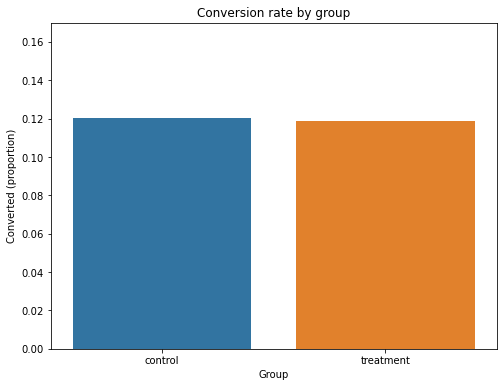

In [30]:
def visualise(df):
    conversion_rates = df.groupby('group')['converted']

 

    std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
    se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion 
                                                     # (std / sqrt(n))

 

    conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
    conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

 

    conversion_rates.style.format('{:.3f}')
    print(conversion_rates)
     
    plt.figure(figsize=(8,6))

 

    sns.barplot(x=df['group'], y=df['converted'], ci=False)

 

    plt.ylim(0, 0.17)
    plt.title('Conversion rate by group')
    plt.xlabel('Group')
    plt.ylabel('Converted (proportion)');

 

visualise(df)     

Based on the graphs, the two designs performed very similarly.

The new design performs slightly better average conversion rate.


## Calculating effect size based on our expected rates.

### calculating sample size needed

In [31]:
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

#calculate effect sizze based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1)

#calculate sample size needed 

required_n = ceil(required_n)
print('We would need at least {0} observation for each group and have a 90% chance to test it is significantly significant'.format(required_n))

We would need at least 4720 observation for each group and have a 90% chance to test it is significantly significant


In [32]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state =22)

treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state =22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop=True, inplace = True)

In [33]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
def ZTest(df):
    control_results = df[df['group'] == 'control']['converted']
    treatment_results = df[df['group'] == 'treatment']['converted']
    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

 

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

 

    if pval < 0.05:
        print(f'p-value: {pval:.3f}. there is a significant difference between treatment and control group')
    else:
        print(f'p-value: {pval:.3f}. there is no significant difference between treatment and control group')
        
    print('')   
    print(f'z statistic: {z_stat:.2f}')     
    print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

 

ZTest(df)

p-value: 0.232. there is no significant difference between treatment and control group

z statistic: 1.19
ci 95% for control group: [0.118, 0.122]
ci 95% for treatment group: [0.117, 0.120]


<img src="downloads/MicrosoftTeams-image.png">

In [35]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(formula = 'converted ~ landing_page + group ', data= ab_test).fit()
aov_table = anova_lm(model,typ = 2)
print(np.round(aov_table,4))

                 sum_sq      df         F  PR(>F)
landing_page    13.8153     1.0  126.7468     0.0
group           15.4583     1.0  141.8203     0.0
Residual      1028.7345  9438.0       NaN     NaN
